<a href="https://colab.research.google.com/github/valdesius/Decision-tree/blob/main/1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = data.data
features = data.feature_names
y = data.target
df = pd.DataFrame(X, columns=features)
df['target'] = y

features = ['AveRooms', 'Population']

df = df[features + ['target']]
df = df.head(5)
df.head()

,AveRooms,Population,target
0,6.984127,322.0,4.526
1,6.238137,2401.0,3.585
2,8.288136,496.0,3.521
3,5.817352,558.0,3.413
4,6.281853,565.0,3.422


**Создаем класс узла с атрибутами:**
* ссылка на правый дочерний узел
* ссылка на левый дочерний узел
* среднеквадратичная ошибка для данного узла
* количество обучающих примеров
* значение, которое предсказывает данный узел
* индекс признака, по которому происходит разделение в данном узле
* пороговое значение, по которому происходит разделение в данном узле

In [ ]:
class Node:
    def __init__(self, right=None, left=None, mse=None, samples=None, value=None, feature=None, threshold=None):
        self.right = right
        self.left = left
        self.mse = mse
        self.samples = samples
        self.value = value
        self.feature = feature
        self.threshold = threshold

Метод для расчета *среднеквадратичой ошибки* для узла

In [ ]:
import numpy as np

def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

Информационный выигрыш используется для определения наиболее оптимального признака и порогов разбиения


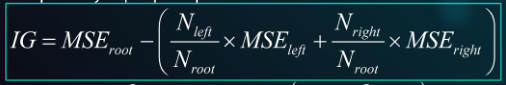

*Для одного конкретного разбиения данных*

In [ ]:
def information_gain(y_root, y_left, y_right):
    mse_root = mse(y_root)
    mse_left = mse(y_left)
    mse_right = mse(y_right)

    n_root = len(y_root)
    n_left = len(y_left)
    n_right = len(y_right)

    ig = mse_root - ((n_left / n_root) * mse_left + (n_right / n_root) * mse_right)
    return ig

**Пороги разбиения**. Сначала нужно отсортировать значения признака по возрастанию, а потом берем среднее между соседними значениями

In [ ]:
def calculate_thresholds(df, feature):
    df_sorted = df.sort_values(by=feature)
    values = df_sorted[feature].values
    thresholds = [(values[i] + values[i + 1]) / 2 for i in range(len(values) - 1)]
    return thresholds

*Информационный выигрыш для всех возможных порогов разбиения для одного признака*

In [ ]:
def calculate_information_gain(df, feature, thresholds):
    gains = []
    for threshold in thresholds:
        left_mask = df[feature] <= threshold
        right_mask = df[feature] > threshold

        y_root = df['target'].values
        y_left = df[left_mask]['target'].values
        y_right = df[right_mask]['target'].values

        ig = information_gain(y_root, y_left, y_right)
        gains.append(ig)

    return gains

**Создание узла**

```
def create_node(df, features)
```выбирает лучший признак и порог для разбиения данных, а затем создает узел с этими параметрами. Если нет подходящего признака для разбиения, функция создает *листовой узел*

In [ ]:
def create_node(df, features):
    best_feature = None
    best_threshold = None
    max_gain = -np.inf

    for feature in features:
        thresholds = calculate_thresholds(df, feature)
        if len(thresholds) == 0:
            continue
        gains = calculate_information_gain(df, feature, thresholds)
        max_gain_feature = max(gains)

        if max_gain_feature > max_gain:
            max_gain = max_gain_feature
            best_feature = feature
            best_threshold = thresholds[gains.index(max_gain_feature)]

    if best_feature is None:
        y_root = df['target'].values
        mse_root = mse(y_root)
        samples_root = len(y_root)
        value_root = np.mean(y_root)

        return Node(
            mse=mse_root,
            samples=samples_root,
            value=value_root
        ), None, None

    left_mask = df[best_feature] <= best_threshold
    right_mask = df[best_feature] > best_threshold

    y_root = df['target'].values
    y_left = df[left_mask]['target'].values
    y_right = df[right_mask]['target'].values

    mse_root = mse(y_root)
    samples_root = len(y_root)
    value_root = np.mean(y_root)

    node = Node(
        mse=mse_root,
        samples=samples_root,
        value=value_root,
        feature=best_feature,
        threshold=best_threshold
    )

    return node, left_mask, right_mask

**Рекурсивно строим дерево решений**

In [ ]:
def build_tree(df, features, depth=0, max_depth=5):
    if depth >= max_depth:
        y_root = df['target'].values
        mse_root = mse(y_root)
        samples_root = len(y_root)
        value_root = np.mean(y_root)
        return Node(
            mse=mse_root,
            samples=samples_root,
            value=value_root
        )

    node, left_mask, right_mask = create_node(df, features)

    if left_mask is not None:
        left_df = df[left_mask]
        node.left = build_tree(left_df, features, depth + 1, max_depth)

    if right_mask is not None:
        right_df = df[right_mask]
        node.right = build_tree(right_df, features, depth + 1, max_depth)

    return node

**Строим графически дерево**

In [ ]:
def plot_custom_tree(node, ax, x, y, dx, dy, features):
    if node is not None:
        if node.feature is not None:
            ax.text(x, y, f"{node.feature} <= {node.threshold:.2f}\nsquared_error: {node.mse:.3f}\nSamples: {node.samples}\nValue: {node.value:.3f}",
                    bbox=dict(facecolor='lightblue', alpha=0.5),
                    horizontalalignment='center',
                    verticalalignment='center')
        else:
            ax.text(x, y, f"Leaf Node\nsquared_error: {node.mse:.3f}\nSamples: {node.samples}\nValue: {node.value:.3f}",
                    bbox=dict(facecolor='lightgreen', alpha=0.5),
                    horizontalalignment='center',
                    verticalalignment='center')

        if node.left is not None:
            ax.plot([x, x - dx], [y, y - dy], 'k-')
            plot_custom_tree(node.left, ax, x - dx, y - dy, dx, dy, features)

        if node.right is not None:
            ax.plot([x, x + dx], [y, y - dy], 'k-')
            plot_custom_tree(node.right, ax, x + dx, y - dy, dx / 2, dy, features)

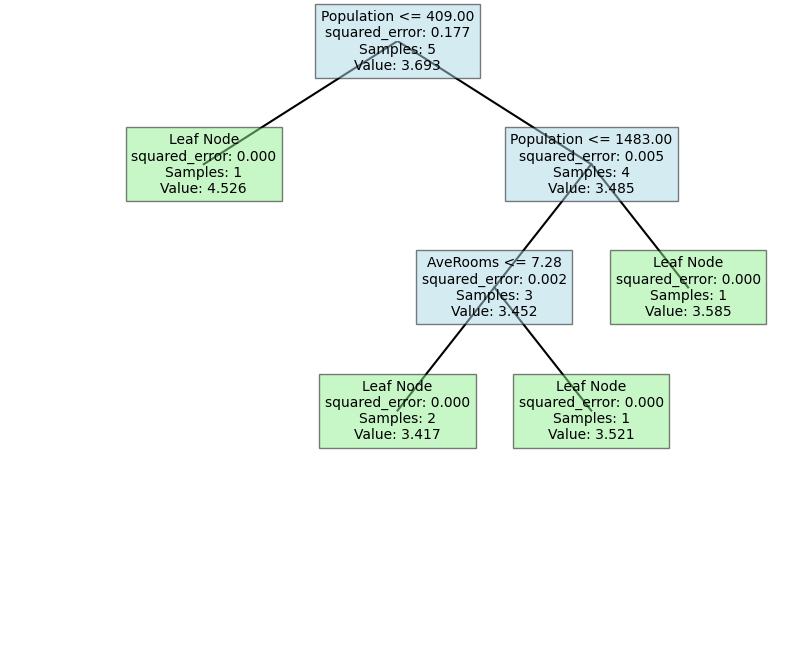

In [ ]:
import matplotlib.pyplot as plt

root = build_tree(df, features, max_depth=3)

fig, ax = plt.subplots(figsize=(10, 8))
plot_custom_tree(root, ax, 0, 1, 0.5, 0.2, features)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()

# Модель DecisionTreeRegressor

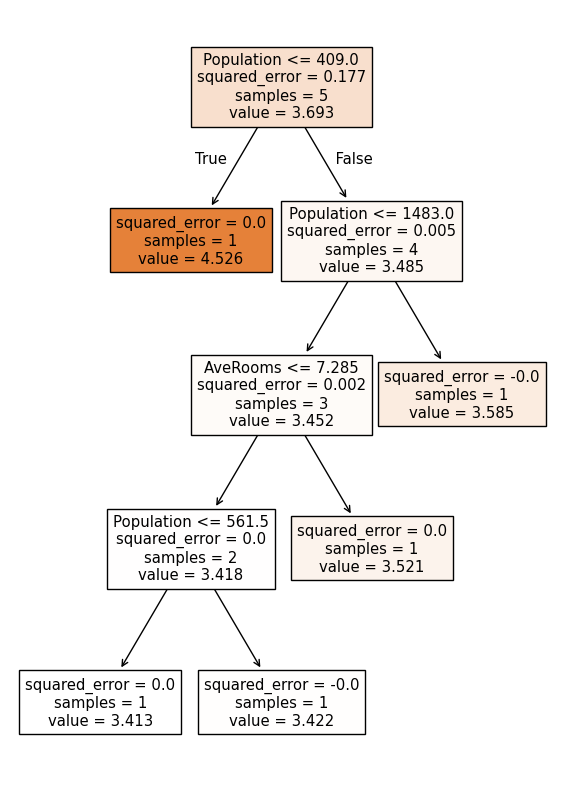

In [ ]:
df_sample = df.head(5)
X_selected = df_sample[features]
y_selected = df_sample['target']
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeRegressor(random_state=1)
tree.fit(X_selected, y_selected)
plt.figure(figsize=(7, 10))
plot_tree(tree, feature_names=features, filled=True)
plt.show()